# Topic Modeling on HateSpeech-Kenya Dataset
Dataset: https://www.kaggle.com/datasets/edwardombui/hatespeech-kenya

### Workflow
<ol><li>Load the dataset (hatespeech-kenya).
<li>Preprocess the data (cleaning, tokenization, etc.).
<li> Build a dictionary and document-term matrix (use 5000 features)
<li> Train an LDA model using gensim.
<li> Visualize topics using pyLDAvis.
<li> Evaluate topics for interpretability.</ol>

In [ ]:
# Step 0: Install required packages (run once)
!pip install gensim pyLDAvis pandas numpy matplotlib seaborn scikit-learn wordcloud nltk -q

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from gensim import corpora
from gensim.models import LdaMulticore
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import warnings
warnings.filterwarnings("ignore")

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

print("Libraries imported and NLTK data downloaded.")

Libraries imported and NLTK data downloaded.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Step 1: Load the dataset

In [ ]:
# Upload the CSV file from Kaggle: "HateSpeech_Kenya.csv"

df = pd.read_csv('/content/sample_data/HateSpeech_Kenya.csv')

print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset shape: (48076, 5)

Columns: ['hate_speech', 'offensive_language', 'neither', 'Class', 'Tweet']

First few rows:


,hate_speech,offensive_language,neither,Class,Tweet
0,0,0,3,0,['The political elite are in desperation. Ordi...
1,0,0,3,0,"[""Am just curious the only people who are call..."
2,0,0,3,0,['USERNAME_3 the area politicians are the one ...
3,0,0,3,0,['War expected in Nakuru if something is not d...
4,0,0,3,0,['USERNAME_4 tells kikuyus activists that they...


In [ ]:
# Explore class distribution (if labeled)
print(df['Class'].value_counts())  # or adjust column name

Class
0    36352
1     8543
2     3181
Name: count, dtype: int64


## Step 2: Text Preprocessing

In [ ]:
# Identify the correct text column (common names)
nltk.download('punkt_tab')

text_col = None
for col in ['Tweet']:
    if col in df.columns:
        text_col = col
        break

if text_col is None:
    # If not found, print columns and pick manually
    print("Available columns:", df.columns.tolist())
    text_col = input("Enter the name of the text column: ")

print(f"Using text column: {text_col}")

# Extract texts
texts = df[text_col].astype(str)

# Preprocessing function
stop_words = set(stopwords.words('english'))
# Add common Swahili/ Sheng / Kenyan online slang stopwords (optional but helpful)
extra_stopwords = {'ni', 'wa', 'na', 'ya', 'kwa', 'ni', 'lakini', 'nawe', 'mimi', 'wewe', 'yeye',
                   'sisi', 'nyinyi', 'hao', 'hii', 'hizi', 'hiyo', 'hizo', 'hapa', 'pale', 'humu',
                   'kule', 'ndio', 'hapana', 'bila', 'kila', 'baada', 'kabla', 'hadi', 'zaidi',
                   'si', 'je', 'kwani', 'kwamba', 'ili', 'ambao', 'ambayo', 'ambazo', 'watu',
                   'msee', 'bro', 'sis', 'dem', 'aki', 'ama', 'sasa', 'tu', 'nioe', 'wasee'}
stop_words.update(extra_stopwords)

stemmer = PorterStemmer()

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', text)
    # Remove mentions (@user) and hashtags
    text = re.sub(r'@\w+|#\w+', ' ', text)
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and short words
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    # Optional: Stemming (can also use lemmatization)
    tokens = [stemmer.stem(word) for word in tokens]
    return tokens

print("Preprocessing texts...")
processed_texts = texts.apply(preprocess_text)

# Remove empty documents
processed_texts = processed_texts[processed_texts.apply(len) > 0]

print(f"Number of documents after cleaning: {len(processed_texts)}")
print("Sample processed text:", processed_texts.iloc[0])

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Using text column: Tweet
Preprocessing texts...
Number of documents after cleaning: 48031
Sample processed text: ['polit', 'elit', 'desper', 'ordinari', 'kalenjin', 'suspici', 'kikuyu', 'commun']


## Step 3: Create Dictionary and Document-Term Matrix (with max 5000 features)

In [ ]:
# Create dictionary
dictionary = corpora.Dictionary(processed_texts)

# Filter extremes: remove terms appearing in <5 docs or >70% of docs
dictionary.filter_extremes(no_below=5, no_above=0.7, keep_n=5000)

print(f"Dictionary size after filtering: {len(dictionary)} tokens")

# Create Bag-of-Words corpus
corpus = [dictionary.doc2bow(text) for text in processed_texts]

print(f"Corpus created with {len(corpus)} documents.")

Dictionary size after filtering: 5000 tokens
Corpus created with 48031 documents.


## Step 4: Train LDA Model using Gensim

In [ ]:
# Optimal number of topics? Let's try 8–12 for hate speech data (ethnicity, politics, gender, etc.)
NUM_TOPICS = 10

lda_model = LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    num_topics=NUM_TOPICS,
    random_state=42,
    chunksize=2000,
    passes=10,
    alpha='symmetric',
    eta='auto',
    workers=4,  # adjust based on your CPU
    eval_every=1,
    per_word_topics=True
)

print("LDA Model Training Completed!")

LDA Model Training Completed!


In [ ]:
# Display top words per topic
print("Top words per topic:\n")
for idx in range(NUM_TOPICS):
    print(f"Topic #{idx + 1}:")
    words = lda_model.print_topic(idx, topn=10)
    print(words)
    print()

Top words per topic:

Topic #1:
0.016*"elect" + 0.013*"like" + 0.013*"know" + 0.012*"maasai" + 0.012*"ye" + 0.011*"chase" + 0.010*"peopl" + 0.009*"well" + 0.008*"still" + 0.008*"free"

Topic #2:
0.014*"polic" + 0.012*"law" + 0.012*"must" + 0.012*"iebc" + 0.011*"media" + 0.010*"state" + 0.010*"offic" + 0.010*"jubile" + 0.010*"court" + 0.007*"kenya"

Topic #3:
0.528*"usernam" + 0.011*"kwao" + 0.011*"warudi" + 0.009*"luhya" + 0.008*"lmao" + 0.007*"kisii" + 0.007*"kihii" + 0.005*"kamba" + 0.005*"true" + 0.004*"lol"

Topic #4:
0.019*"masai" + 0.012*"kenya" + 0.011*"maasai" + 0.011*"happen" + 0.010*"nasa" + 0.010*"kuria" + 0.009*"time" + 0.009*"come" + 0.009*"mara" + 0.008*"get"

Topic #5:
0.084*"kikuyu" + 0.041*"luo" + 0.028*"hate" + 0.022*"kalenjin" + 0.016*"tribal" + 0.016*"peopl" + 0.016*"luhya" + 0.016*"kenyan" + 0.014*"tribe" + 0.013*"say"

Topic #6:
0.088*"nyakundi" + 0.011*"cyprian" + 0.011*"arrest" + 0.010*"like" + 0.010*"boy" + 0.009*"chase" + 0.008*"man" + 0.006*"child" + 0.006*"o

## Step 5: Visualize with pyLDAvis

In [ ]:
# Prepare visualization
vis = gensimvis.prepare(lda_model, corpus, dictionary, mds='mmds', sort_topics=False)

# Display in notebook
pyLDAvis.display(vis)

## Step 6: Evaluate Topics for Interpretability


In [ ]:
# Compute Coherence Score (higher is better)
from gensim.models.coherencemodel import CoherenceModel

coherence_model = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"C_V Coherence Score: {coherence_score:.4f}")

# Manual interpretation (example labels based on common Kenyan hate speech themes)
topic_labels = {
    0: "Ethnic Attacks (Luo vs Kikuyu)",
    1: "Political Incitement & Election Violence",
    2: "Gender-Based Hate & Misogyny",
    3: "Religious Intolerance",
    4: "Raila/Ruto Political Tribalism",
    5: "General Insults & Profanity",
    6: "Anti-Kikuyu Sentiment",
    7: "Calls for Violence/Genocide Rhetoric",
    8: "Anti-Kalenjin Hate",
    9: "Police Brutality & State Criticism"
}

print("\nSuggested Topic Labels (based on inspection):")
for i, label in topic_labels.items():
    # Corrected line: Extract the word (first element) from each tuple
    top_words = [word_prob[0] for word_prob in lda_model.show_topic(i, 10)]
    print(f"Topic {i+1}: {label}")
    print("   →", ", ".join(top_words))
    print()

C_V Coherence Score: 0.3733

Suggested Topic Labels (based on inspection):
Topic 1: Ethnic Attacks (Luo vs Kikuyu)
   → elect, like, know, maasai, ye, chase, peopl, well, still, free

Topic 2: Political Incitement & Election Violence
   → polic, law, must, iebc, media, state, offic, jubile, court, kenya

Topic 3: Gender-Based Hate & Misogyny
   → usernam, kwao, warudi, luhya, lmao, kisii, kihii, kamba, true, lol

Topic 4: Religious Intolerance
   → masai, kenya, maasai, happen, nasa, kuria, time, come, mara, get

Topic 5: Raila/Ruto Political Tribalism
   → kikuyu, luo, hate, kalenjin, tribal, peopl, luhya, kenyan, tribe, say

Topic 6: General Insults & Profanity
   → nyakundi, cyprian, arrest, like, boy, chase, man, child, one, get

Topic 7: Anti-Kikuyu Sentiment
   → need, money, kenyan, know, use, pay, elect, vote, peac, jubile

Topic 8: Calls for Violence/Genocide Rhetoric
   → hawa, wakikuyu, wajaluo, kama, wazungu, sana, ati, wacha, wakisii, wako

Topic 9: Anti-Kalenjin Hate
   →

In [ ]:
# Find dominant topic for each document
def get_dominant_topic(ldamodel, corpus):
    topics = []
    for doc in corpus:
        topic_probs = ldamodel.get_document_topics(doc)
        dominant = max(topic_probs, key=lambda x: x[1])
        topics.append((dominant[0], dominant[1]))
    return topics

df_clean = df.loc[processed_texts.index].copy()
dominant_topics = get_dominant_topic(lda_model, corpus)
df_clean['dominant_topic'] = [t[0] + 1 for t in dominant_topics]
df_clean['topic_prob'] = [t[1] for t in dominant_topics]

print("Dominant topic distribution:")
print(df_clean['dominant_topic'].value_counts().sort_index())

Dominant topic distribution:
dominant_topic
1      5928
2      3424
3      3169
4      5221
5     10068
6      3595
7      4916
8      2928
9      2872
10     5910
Name: count, dtype: int64


Next Steps You Can Add:

Hyperparameter tuning (grid search over number of topics using coherence)<br>
Compare with BERTopic (modern alternative)
Classify hate vs non-hate using topic proportions as features

Training LDA model with 2 topics...


Training LDA model with 4 topics...
Training LDA model with 6 topics...
Training LDA model with 8 topics...
Training LDA model with 10 topics...
Training LDA model with 12 topics...
Training LDA model with 14 topics...
Training LDA model with 16 topics...
Training LDA model with 18 topics...


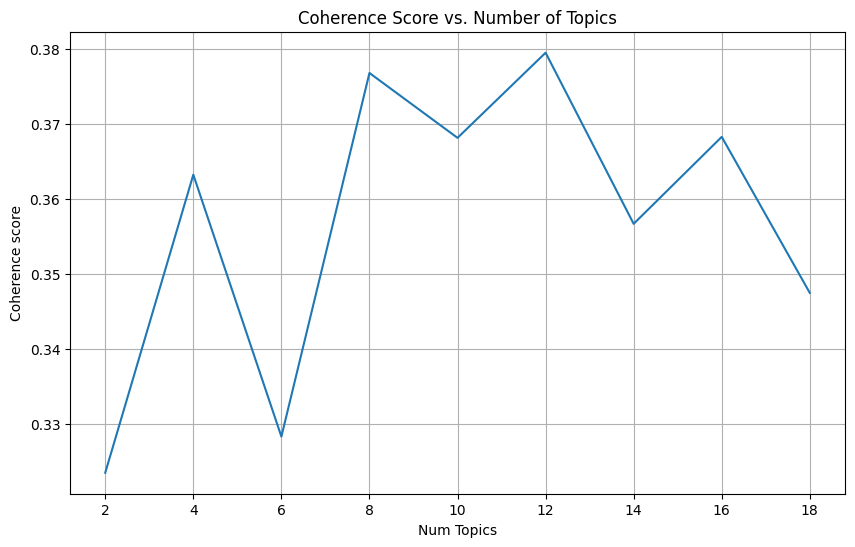


The optimal number of topics is: 12 (Coherence Score: 0.3794)


In [ ]:
import matplotlib.pyplot as plt

# Function to compute coherence values for various number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(f"Training LDA model with {num_topics} topics...")
        model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, chunksize=2000, passes=10, alpha='symmetric', eta='auto', workers=4)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Define parameters for the grid search
start = 2
limit = 20  # Try up to 20 topics
step = 2

# Compute coherence scores
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_texts, limit=limit, start=start, step=step)

# Plot coherence values
x = range(start, limit, step)
plt.figure(figsize=(10, 6))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("Coherence Score vs. Number of Topics")
plt.xticks(x)
plt.grid(True)
plt.show()

# Find the optimal number of topics
optimal_idx = coherence_values.index(max(coherence_values))
optimal_num_topics = x[optimal_idx]
print(f"\nThe optimal number of topics is: {optimal_num_topics} (Coherence Score: {max(coherence_values):.4f})")

# You can now re-train your LDA model with optimal_num_topics if desired
# lda_optimal_model = model_list[optimal_idx]